# Data Input

In [1]:
from urllib.request import urlretrieve
import shutil

url = "https://s3.amazonaws.com/tripdata/202401-citibike-tripdata.zip"
urlretrieve(url, "202401-citibike-tripdata.zip") # Download dataset
shutil.unpack_archive("202401-citibike-tripdata.zip", "202401-citibike-tripdata") # Unzip dataset

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import os

csv_dir = "/content/202401-citibike-tripdata/"
csv_files = [f for f in os.listdir(csv_dir) if f.endswith('.csv')]
dfs = []

for csv_file in csv_files:
    file_path = os.path.join(csv_dir, csv_file)
    df_temp = pd.read_csv(file_path, dtype={
    "start_station_id": "string",
    "end_station_id": "string"
}, parse_dates=["started_at", "ended_at"])  # convert station ids to string for now
    dfs.append(df_temp)

df = pd.concat(dfs, ignore_index=True) # combine the 2 csv files
print(df.head())
print(f"\nShape of the combined DataFrame: {df.shape}")

            ride_id  rideable_type              started_at  \
0  62EF1AC5BE598131   classic_bike 2024-01-24 09:03:33.533   
1  8464E543DAB27DBF   classic_bike 2024-01-30 08:21:29.510   
2  9C04FDC8549F5205  electric_bike 2024-01-22 21:18:25.199   
3  7DD1703A3E0D8833  electric_bike 2024-01-31 22:15:49.861   
4  6A96FCD170996E59   classic_bike 2024-01-29 22:52:28.276   

                 ended_at         start_station_name start_station_id  \
0 2024-01-24 09:06:53.535           E 102 St & 1 Ave          7407.13   
1 2024-01-30 08:29:03.304           E 102 St & 1 Ave          7407.13   
2 2024-01-22 21:26:24.647            W 35 St & 8 Ave          6526.01   
3 2024-01-31 22:22:45.520  Warren St & Roosevelt Ave          6346.07   
4 2024-01-29 22:57:05.099            6 Ave & W 33 St          6364.07   

           end_station_name end_station_id  start_lat  start_lng    end_lat  \
0  E 103 St & Lexington Ave        7463.09  40.786995 -73.941648  40.790305   
1           E 91 St & 2 Ave   

# Data Preprocessing

In [ ]:
mask_start = ~df["start_station_id"].str.replace(".", "", regex=False).str.isnumeric()
mask_end = ~df["end_station_id"].str.replace(".", "", regex=False).str.isnumeric() # Find non-numeric station ids
mask = mask_start | mask_end
print(f"Found {mask.sum()} rows with non-numeric station IDs")
df.loc[mask, ["start_station_id", "end_station_id"]].head()

Found 337 rows with non-numeric station IDs


,start_station_id,end_station_id
29386,SYS016,4768.02
52517,6740.10,HB610
55975,6740.10,HB610
67218,SYS016,5170.01
68710,6432.11,JC035


In [ ]:
df = df[~mask].copy() # Remove the station ids
df["start_station_id"] = df["start_station_id"].astype(float)
df["end_station_id"] = df["end_station_id"].astype(float) # Convert station ids to float

In [ ]:
na_station_ids_df = df[df['start_station_id'].isna() | df['end_station_id'].isna()]
print(f"Number of rows with N/A station IDs: {len(na_station_ids_df)}")
df = df.dropna(subset=['start_station_id', 'end_station_id'])

Number of rows with N/A station IDs: 0


# Data Visualization

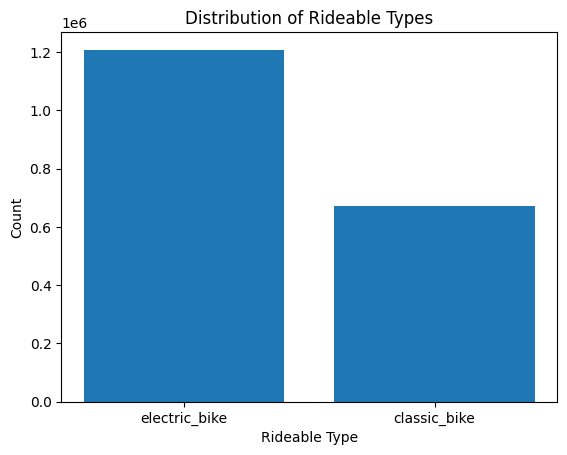

In [ ]:
import matplotlib.pyplot as plt

rideable_type_counts = df["rideable_type"].value_counts()

plt.bar(rideable_type_counts.index, rideable_type_counts.values)
plt.xlabel("Rideable Type")
plt.ylabel("Count")
plt.title("Distribution of Rideable Types")
plt.show()

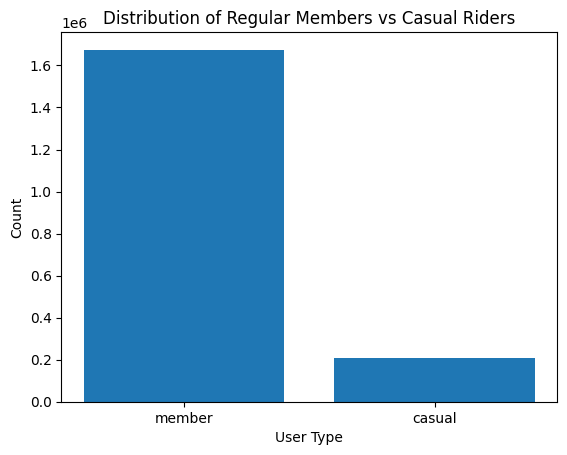

In [ ]:
user_type_counts = df["member_casual"].value_counts()

plt.bar(user_type_counts.index, user_type_counts.values)
plt.xlabel("User Type")
plt.ylabel("Count")
plt.title("Distribution of Regular Members vs Casual Riders")
plt.show()

In [ ]:
start_station_counts = df["start_station_id"].value_counts()
end_station_counts = df["end_station_id"].value_counts()
start_station_df = start_station_counts.reset_index()
start_station_df.columns = ["station_id", "start_count"]

end_station_df = end_station_counts.reset_index()
end_station_df.columns = ["station_id", "end_count"]

station_counts_df = pd.merge(start_station_df, end_station_df, on="station_id", how="outer").fillna(0)
station_counts_df.head()

,station_id,start_count,end_count
0,2733.03,64.0,69
1,2782.02,102.0,97
2,2821.05,156.0,167
3,2832.03,119.0,124
4,2861.02,113.0,100


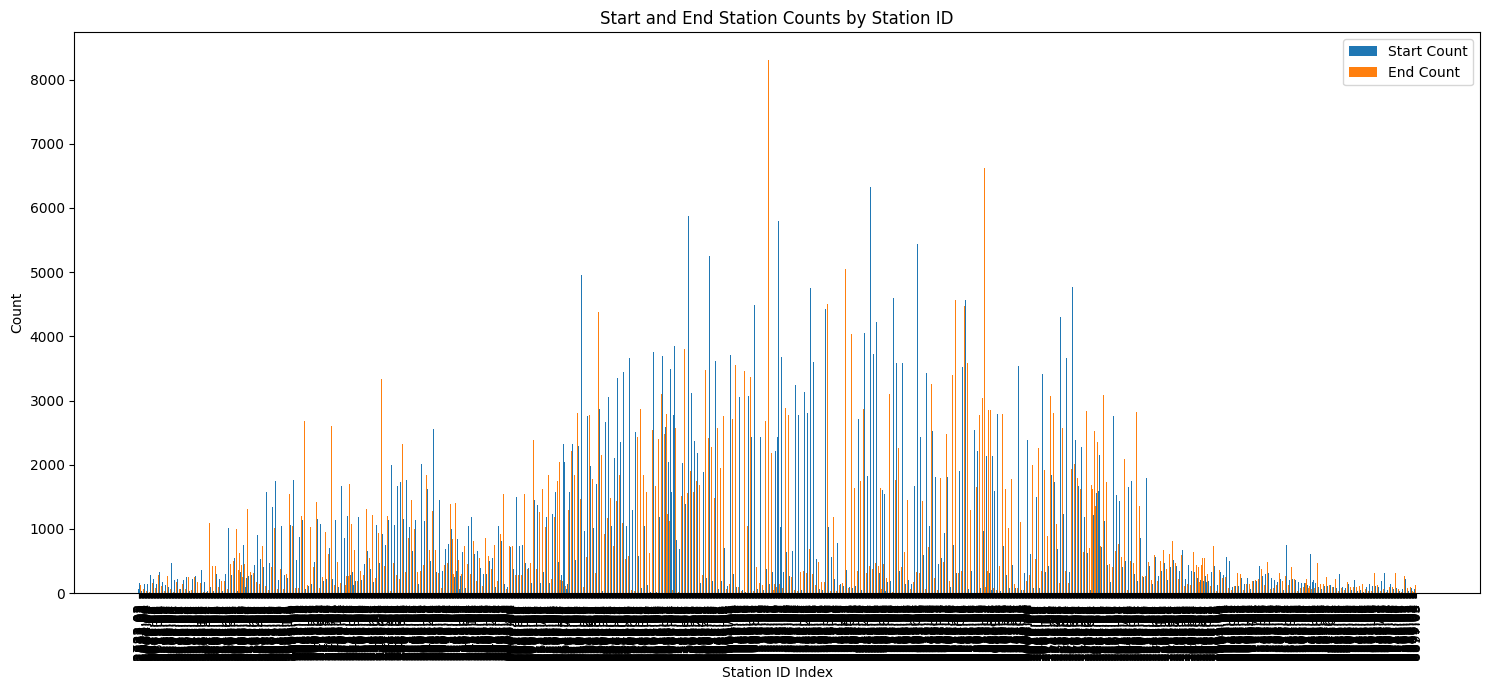

In [ ]:
import numpy as np

n_stations = len(station_counts_df)
bar_width = 0.35
index = np.arange(n_stations)

plt.figure(figsize=(15, 7))
plt.bar(index, station_counts_df["start_count"], bar_width, label="Start Count")
plt.bar(index + bar_width, station_counts_df["end_count"], bar_width, label="End Count")

plt.xlabel("Station ID Index")
plt.ylabel("Count")
plt.title("Start and End Station Counts by Station ID")
plt.xticks(index + bar_width / 2, station_counts_df["station_id"], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
n_stations

2126

In [ ]:
stations_with_high_start_count = station_counts_df[station_counts_df["start_count"] > 6000]
print("Station(s) with start_count > 6000:")
display(stations_with_high_start_count)

Station(s) with start_count > 6000:


,station_id,start_count,end_count
1048,6140.05,8320.0,8309
1162,6331.01,6020.0,6051
1218,6450.05,6325.0,6364
1407,6822.09,6554.0,6615


In [ ]:
print(df.head)

<bound method NDFrame.head of                   ride_id  rideable_type              started_at  \
0        62EF1AC5BE598131   classic_bike 2024-01-24 09:03:33.533   
1        8464E543DAB27DBF   classic_bike 2024-01-30 08:21:29.510   
2        9C04FDC8549F5205  electric_bike 2024-01-22 21:18:25.199   
3        7DD1703A3E0D8833  electric_bike 2024-01-31 22:15:49.861   
4        6A96FCD170996E59   classic_bike 2024-01-29 22:52:28.276   
...                   ...            ...                     ...   
1888080  53C5A7DDC930FE68  electric_bike 2024-01-19 08:11:31.812   
1888081  80C14103C204CD47  electric_bike 2024-01-23 08:50:57.782   
1888082  E1EE9037A8CB6101  electric_bike 2024-01-21 14:16:24.984   
1888083  DA5E681B117190A0  electric_bike 2024-01-23 09:02:49.848   
1888084  C29B38D0D93E10BA   classic_bike 2024-01-26 09:39:15.238   

                       ended_at         start_station_name  start_station_id  \
0       2024-01-24 09:06:53.535           E 102 St & 1 Ave           7407

so my basic idea here is to classify trips as normal or unusually long using stats

In [ ]:
# finding the duration of the trip first
# converting them to date time again to avoid it breaking the calculation(initially were converted to string)
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])
# total duration in minutes
df['total_timetaken'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60

In [ ]:
print(df['total_timetaken'])

0           3.333367
1           7.563233
2           7.990800
3           6.927650
4           4.613717
             ...    
1888080     6.864117
1888081    21.664250
1888082     5.825233
1888083    18.494417
1888084     3.503483
Name: total_timetaken, Length: 1881640, dtype: float64


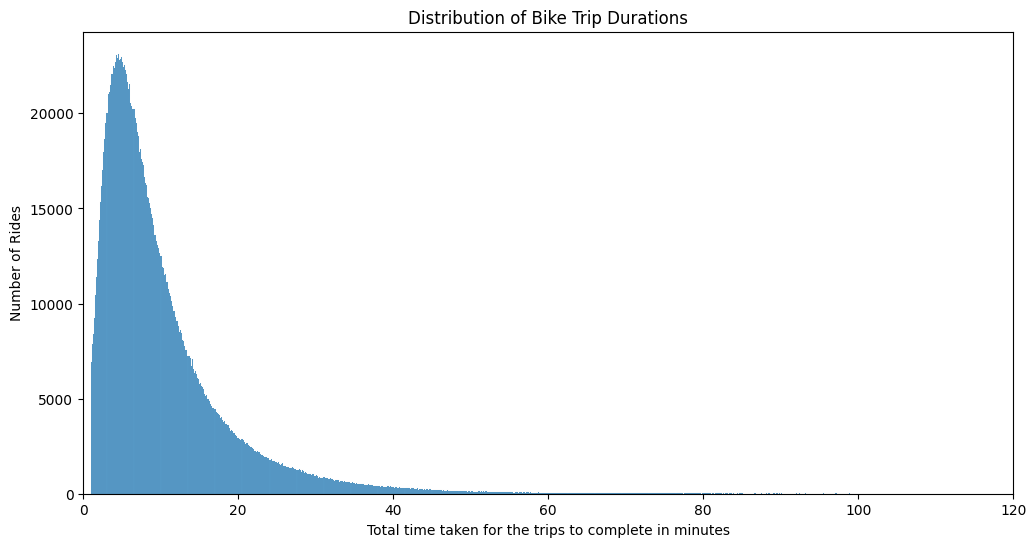

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.histplot(df['total_timetaken'])
plt.xlim(0, 120)
plt.xlabel('Total time taken for the trips to complete in minutes')
plt.ylabel('Number of Rides')
plt.title('Distribution of Bike Trip Durations')
plt.show()


In [ ]:
mean = df['total_timetaken'].mean()
print("Mean duration:",mean,"minutes")

Mean duration: 10.84669260687485 minutes


In [ ]:
standard_deviation = df['total_timetaken'].std()
print("Standard deviation:",standard_deviation,"minutes")

Standard deviation: 20.778979808110133 minutes


In [ ]:
lower_threshold = mean - (2*standard_deviation)
upper_threshold = mean + (2*standard_deviation)
print(lower_threshold,upper_threshold)

-30.711267009345416 52.40465222309511


classification

In [ ]:
def classification_ofrides(ride):
  if ride <= lower_threshold:
    return "Too short and indicates unusual ride"
  elif ride >= upper_threshold:
    return "Too long and indicates unusual ride"
  else:
    return "Normal ride"

In [ ]:
df['duration_categorization'] = np.where(df['total_timetaken'] < lower_threshold,
                                   'Too short and indicates unusual ride',
                                   np.where(df['total_timetaken'] > upper_threshold,
                                            'Too long and indicates unusual ride',
                                            'Normal ride'))

In [ ]:
print(df['total_timetaken'].value_counts())

total_timetaken
4.539400     15
6.278917     13
4.419683     12
5.388950     12
4.582550     12
             ..
8.031550      1
28.187167     1
45.048067     1
23.997633     1
14.867483     1
Name: count, Length: 978196, dtype: int64


In [ ]:
print(df.head(20))

             ride_id  rideable_type              started_at  \
0   62EF1AC5BE598131   classic_bike 2024-01-24 09:03:33.533   
1   8464E543DAB27DBF   classic_bike 2024-01-30 08:21:29.510   
2   9C04FDC8549F5205  electric_bike 2024-01-22 21:18:25.199   
3   7DD1703A3E0D8833  electric_bike 2024-01-31 22:15:49.861   
4   6A96FCD170996E59   classic_bike 2024-01-29 22:52:28.276   
5   B7E5E6FAA9636FD5  electric_bike 2024-01-18 19:34:03.148   
6   7DFBA0228776696D  electric_bike 2024-01-20 11:53:22.638   
7   12FBBCF285A43999  electric_bike 2024-01-30 07:45:29.603   
8   815B668E8ADAFDA8  electric_bike 2024-01-16 06:50:43.736   
9   7D6E05FA1FDC13DD  electric_bike 2024-01-23 16:03:15.146   
10  DC9D566EDE21493D  electric_bike 2024-01-18 20:14:30.108   
11  AA171066E1FBBA3D  electric_bike 2024-01-26 13:38:48.610   
12  71AB47656B2090B8   classic_bike 2024-01-27 15:50:16.756   
13  A42F107BB6BD3833   classic_bike 2024-01-26 16:28:57.794   
14  B4F6D243AF91588B  electric_bike 2024-01-29 19:13:26

In [ ]:
print(df['duration_categorization'].value_counts())


duration_categorization
Normal ride                            1868753
Too long and indicates unusual ride      12887
Name: count, dtype: int64


In [ ]:
print(df[df['duration_categorization'] == 'Too long and indicates unusual ride'].head())

              ride_id  rideable_type              started_at  \
56   9D9344AC9224D0D4  electric_bike 2024-01-25 00:14:53.275   
608  A2E716E3D6E8C7C8  electric_bike 2024-01-18 12:35:04.674   
649  F50D72B4A71740BB  electric_bike 2024-01-27 14:22:14.632   
797  EB86610B2D5805C2   classic_bike 2024-01-15 12:27:02.200   
966  AFA10FA3DF6182A7  electric_bike 2024-01-27 08:09:15.642   

                   ended_at        start_station_name  start_station_id  \
56  2024-01-25 01:41:31.987  Parkside Ave & Ocean Ave           3448.02   
608 2024-01-18 13:36:48.179      Hudson St & Reade St           5359.10   
649 2024-01-27 16:49:47.313      Maiden Ln & Pearl St           5065.10   
797 2024-01-15 13:35:08.045   Lafayette St & Grand St           5422.09   
966 2024-01-27 09:10:55.468            43 Ave & 42 St           6251.06   

              end_station_name  end_station_id  start_lat  start_lng  \
56      Ocean Ave & Crooke Ave         3408.05  40.654850 -73.962170   
608            W 52 

In [ ]:
print(df[df['duration_categorization'] == 'Too short and indicates unusual ride'].head())

Empty DataFrame
Columns: [ride_id, rideable_type, started_at, ended_at, start_station_name, start_station_id, end_station_name, end_station_id, start_lat, start_lng, end_lat, end_lng, member_casual, total_timetaken, duration_categorization]
Index: []


In [ ]:
# df[['ride_id', 'start_station_name', 'end_station_name', 'total_timetaken', 'duration_categorization']].to_csv(
#     'trip_categorization_results.csv', index=False
# )

ml model -> to use the stats info as labels and feed that into the ml model along with other features like bike type, user type, time of day, and start/end locations. Purpose -> The purpose of this approach was twofold: first, to see if the model could learn to predict the ride categories correctly, and second, to check how well its predictions match the original statistical labels.

In [ ]:
from sklearn.preprocessing import LabelEncoder
le_ridetype = LabelEncoder()
df['rideable_type_transform'] = le_ridetype.fit_transform(df['rideable_type'])


In [ ]:
le_member_casual = LabelEncoder()
df['member_casual_transform'] = le_member_casual.fit_transform(df['member_casual'])


In [ ]:
df['hour'] = df['started_at'].dt.hour

In [ ]:
features = ['rideable_type_transform', 'hour', 'member_casual_transform',
            'start_lat', 'start_lng', 'end_lat', 'end_lng']

In [ ]:
X = df[features]
y = df['duration_categorization']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state = 0 )


In [ ]:
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)


Number transactions X_train dataset:  (1411230, 7)
Number transactions y_train dataset:  (1411230,)
Number transactions X_test dataset:  (470410, 7)
Number transactions y_test dataset:  (470410,)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [ ]:
prediction_y = model.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, prediction_y))

                                     precision    recall  f1-score   support

                        Normal ride       0.99      1.00      1.00    467097
Too long and indicates unusual ride       0.62      0.19      0.29      3313

                           accuracy                           0.99    470410
                          macro avg       0.81      0.59      0.64    470410
                       weighted avg       0.99      0.99      0.99    470410



In [ ]:
print(confusion_matrix(y_test, prediction_y))

[[466722    375]
 [  2700    613]]


In [ ]:
#just to see if stats matches the ml approach

df_test = df.loc[y_test.index].copy()
df_test['ml_predicted_category'] = prediction_y

In [ ]:
df_test['agreement'] = df_test['duration_categorization'] == df_test['ml_predicted_category']
print(df_test['agreement'].value_counts())

agreement
True     467335
False      3075
Name: count, dtype: int64


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, prediction_y)
precision = precision_score(y_test, prediction_y, average='weighted')
recall = recall_score(y_test, prediction_y, average='weighted')
f1 = f1_score(y_test, prediction_y, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Accuracy: 0.9934631491677473
Precision: 0.9916156294590123
Recall: 0.9934631491677473
F1-score: 0.9917044442201236


In [ ]:
df_test[['ride_id', 'start_station_name', 'end_station_name',
         'total_timetaken', 'duration_categorization',
         'ml_predicted_category']].to_csv('tripcategorization_results.csv', index=False)

now looking at the unusual rides:

In [ ]:
misclassified = df_test[df_test['agreement'] == False]
print(misclassified[['ride_id','total_timetaken','duration_categorization','ml_predicted_category']].head())


                  ride_id  total_timetaken  \
1772543  CF484EE45A71DBE7        78.043683   
300268   E63FE8454B3D9CF5       722.671483   
271023   034A6E3B427BF956        58.093167   
91781    72C4E71E13BBC256        78.977017   
1449901  57DAAC1B50626F1D       155.058483   

                     duration_categorization ml_predicted_category  
1772543  Too long and indicates unusual ride           Normal ride  
300268   Too long and indicates unusual ride           Normal ride  
271023   Too long and indicates unusual ride           Normal ride  
91781    Too long and indicates unusual ride           Normal ride  
1449901  Too long and indicates unusual ride           Normal ride  


# 2nd ml idea -> station popularity/busyness :

In [ ]:
df['started_at'] = pd.to_datetime(df['started_at'])
df['hour'] = df['started_at'].dt.hour
# df['minutes'] = df['started_at'].dt.minute
df['day_of_week'] = df['started_at'].dt.dayofweek


In [ ]:
station_busy = df.groupby(
    ['start_station_name', 'day_of_week', 'hour']
).size().reset_index(name='ride_count')

In [ ]:
print(station_busy.head(20))

   start_station_name  day_of_week  hour  ride_count
0    1 Ave & E 110 St            0     1           2
1    1 Ave & E 110 St            0     3           1
2    1 Ave & E 110 St            0     5           1
3    1 Ave & E 110 St            0     6          11
4    1 Ave & E 110 St            0     7          12
5    1 Ave & E 110 St            0     8          14
6    1 Ave & E 110 St            0     9           6
7    1 Ave & E 110 St            0    10           3
8    1 Ave & E 110 St            0    11           8
9    1 Ave & E 110 St            0    12          10
10   1 Ave & E 110 St            0    13          11
11   1 Ave & E 110 St            0    14           4
12   1 Ave & E 110 St            0    15           8
13   1 Ave & E 110 St            0    16          13
14   1 Ave & E 110 St            0    17           7
15   1 Ave & E 110 St            0    18           6
16   1 Ave & E 110 St            0    19          14
17   1 Ave & E 110 St            0    20      

In [ ]:
from sklearn.preprocessing import LabelEncoder

le_station = LabelEncoder()
station_busy['station_id'] = le_station.fit_transform(station_busy['start_station_name'])


In [ ]:
X = station_busy[['day_of_week', 'hour', 'station_id']]
y = station_busy['ride_count']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0
)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Training a randomforest to predict number of rides
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))


MAE: 2.860452981651376
R² Score: 0.8349416944814908


In [ ]:
predictions_df = X_test.copy()
predictions_df['actual_ride_count'] = y_test
predictions_df['predicted_ride_count'] = y_pred

predictions_df['start_station_name'] = le_station.inverse_transform(predictions_df['station_id'])
predictions_df = predictions_df[['start_station_name', 'day_of_week', 'hour', 'actual_ride_count', 'predicted_ride_count']]
predictions_df.to_csv('hourly_ride_predictions.csv', index=False)

print("Predictions saved to hourly_ride_predictions.csv")

Predictions saved to hourly_ride_predictions.csv


In [ ]:
predict_station = "W 21 St & 6 Ave"
predict_day = 24
predict_hour = 16
predict_station_id = le_station.transform([predict_station])[0]

input_data = pd.DataFrame({
    'day_of_week': [predict_day],
    'hour': [predict_hour],
    'station_id': [predict_station_id]
})

predicted_ride_count = model.predict(input_data)
print(f"Predicted number of bikes rented at '{predict_station}' on day {predict_day} at hour {predict_hour}: {predicted_ride_count[0]:.2f}")

Predicted number of bikes rented at 'W 21 St & 6 Ave' on day 24 at hour 16: 71.18


In [ ]:

station_total = df.groupby('start_station_name')['ride_id'].count().reset_index(name='total_rides')


station_total = station_total.sort_values(by='total_rides', ascending=False)

print(station_total)


           start_station_name  total_rides
1938          W 21 St & 6 Ave         8320
8             1 Ave & E 68 St         6554
440           8 Ave & W 31 St         6325
1958          W 31 St & 7 Ave         6020
1019          E 33 St & 1 Ave         5879
...                       ...          ...
607        Borden Ave & 25 St            5
333    56 Ave & Junction Blvd            5
1744     Somers St & Broadway            5
1144  Faile St & Garrison Ave            4
454            87 St & 30 Ave            1

[2122 rows x 2 columns]


Testing on the  month ->

In [ ]:
from urllib.request import urlretrieve
import shutil

url = "https://s3.amazonaws.com/tripdata/202403-citibike-tripdata.zip"
urlretrieve(url, "202403-citibike-tripdata.zip") # Download dataset
shutil.unpack_archive("202403-citibike-tripdata.zip", "202403-citibike-tripdata") # Unzip dataset

In [ ]:
import pandas as pd
import os

csv_dir = "/content/202403-citibike-tripdata/"
csv_files = [f for f in os.listdir(csv_dir) if f.endswith('.csv')]
dfs = []

for csv_file in csv_files:
    file_path = os.path.join(csv_dir, csv_file)
    df_temp = pd.read_csv(file_path, dtype={
    "start_station_id": "string",
    "end_station_id": "string"
}, parse_dates=["started_at", "ended_at"])  # convert station ids to string for now
    dfs.append(df_temp)

df_newdata = pd.concat(dfs, ignore_index=True) # combine the 2 csv files
print(df_newdata.head())
print(f"\nShape of the combined DataFrame: {df_newdata.shape}")

In [ ]:
# Convert to datetime
df_newdata['started_at'] = pd.to_datetime(df_newdata['started_at'])
df_newdata['day_of_week'] = df_newdata['started_at'].dt.dayofweek
df_newdata['hour'] = df_newdata['started_at'].dt.hour
df_newdata['station_id'] = le_station.transform(df_newdata['start_station_name'])
